In [1]:
!pip install datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [8]:
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image
# Define a custom dataset class for Flickr30k
class Flickr30kDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = load_dataset("nlphuji/flickr30k", cache_dir="./huggingface_data")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
        self.cap_per_image = 2

    def __len__(self):
        return self.dataset.num_rows["test"] * self.cap_per_image

    def __getitem__(self, idx):
        original_idx = idx // self.cap_per_image
        # image_path = self.dataset[idx]["image_path"]
        image = self.dataset["test"][original_idx]["image"].convert("RGB")
        image = self.transform(image)

        # You might need to adjust the labels based on your task
        caption = self.dataset["test"][original_idx]["caption"][idx % self.cap_per_image]

        return {"image": image, "caption": caption}

# Create an instance of the custom dataset
flickr30k_custom_dataset = Flickr30kDataset()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
from dataclasses import dataclass


@dataclass
class Config:
    """
    Configuration class for the CLIP training script.
    """

    embed_dim: int = 512  # Embedding dimension
    transformer_embed_dim: int = 768  # Transformer embedding dimension
    max_len: int = 32  # Maximum text length
    text_model: str = "distilbert-base-multilingual-cased"  # Text model name
    epochs: int = 5  # Number of training epochs
    batch_size: int = 128  # Batch size

In [4]:
# Create the DataLoader
clip_dataloader = DataLoader(flickr30k_custom_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


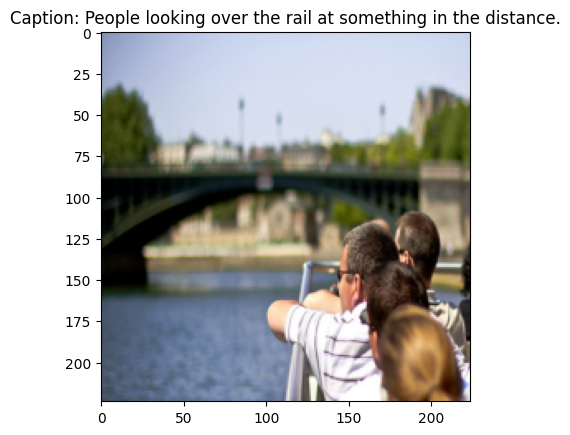

In [6]:
import numpy as np
import matplotlib.pyplot as plt
# Create an iterator from the dataloader
data_iter = iter(clip_dataloader)

# Get one batch
batch = next(data_iter)


image = batch["image"][0]  # Assuming batch size is greater than 0
caption = batch["caption"][0]

# Convert the image tensor to a NumPy array and permute dimensions
image_np = np.transpose(image.numpy(), (1, 2, 0))

# Display the image and caption
plt.imshow(image_np)
plt.title(f"Caption: {caption}")
plt.show()

In [7]:
print("example of a caption in abatch:",  batch["caption"][0])
print("number of captions in each batch:",len(batch["caption"]))

example of a caption in abatch: People looking over the rail at something in the distance.
number of captions in each batch: 128


In [60]:
!pip install git+https://github.com/openai/CLIP.git --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.8 MB/s eta 0:00:00


In [62]:
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def CLIP_loss(logits: torch.Tensor) -> torch.Tensor:
    # Assuming n is the number of classes
    n = logits.shape[1]

    # Create labels tensor
    labels = torch.arange(n).to(device)

    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")

    # Calculate the final loss
    loss = (loss_i + loss_t) / 2

    return loss

def metrics(similarity: torch.Tensor):
    y = torch.arange(len(similarity)).to(similarity.device)
    img2cap_match_idx = similarity.argmax(dim=1)
    cap2img_match_idx = similarity.argmax(dim=0)

    img_acc = (img2cap_match_idx == y).float().mean()
    cap_acc = (cap2img_match_idx == y).float().mean()

    return img_acc, cap_acc

In [63]:
import clip
model, preprocess = clip.load("ViT-B/32", device=device)

image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]


for captions in [true_text, wrong_text]:
    text = clip.tokenize(captions).to(device)

    # with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 51.4MiB/s]


tensor(4.7188, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)
tensor(4.8516, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


In [64]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Projection(nn.Module):
    def __init__(self, d_in: int, d_out: int, p: float = 0.5) -> None:
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_out, bias=False)
        self.linear2 = nn.Linear(d_out, d_out, bias=False)
        self.layer_norm = nn.LayerNorm(d_out)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embed1 = self.linear1(x)
        embed2 = self.drop(self.linear2(F.gelu(embed1)))
        embeds = self.layer_norm(embed1 + embed2)
        return embeds


class VisionEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        base = models.resnet34(pretrained=True)
        d_in = base.fc.in_features
        base.fc = nn.Identity()
        self.base = base
        self.projection = Projection(d_in, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        projected_vec = self.projection(self.base(x))
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


class TextEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        self.base = AutoModel.from_pretrained(Config.text_model)
        self.projection = Projection(Config.transformer_embed_dim, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.base(x)[0]
        out = out[:, 0, :]  # get CLS token output
        projected_vec = self.projection(out)
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len


In [65]:
class Tokenizer:
    def __init__(self, tokenizer: BertTokenizer) -> None:
        self.tokenizer = tokenizer

    def __call__(self, x: str) -> AutoTokenizer:
        return self.tokenizer(
            x, max_length=Config.max_len, truncation=True, padding=True, return_tensors="pt"
        )


In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]

vision_encoder = VisionEncoder(Config.embed_dim).to(device)
caption_encoder = TextEncoder(Config.embed_dim).to(device)
tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model))

for captions in [true_text, wrong_text]:
    text = tokenizer(captions).to(device)

    # with torch.no_grad():
    image_features = vision_encoder(image)
    text_features = caption_encoder(text["input_ids"])

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 152MB/s]


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor(4.8537, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8519, device='cuda:0', grad_fn=<DivBackward0>)


In [67]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from typing import List, Tuple


class CustomModel(nn.Module):
    def __init__(self, lr: float = 1e-3) -> None:
        super().__init__()
        self.vision_encoder = VisionEncoder(Config.embed_dim)
        self.caption_encoder = TextEncoder(Config.embed_dim)
        self.tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model, use_fast=False))
        self.lr = lr
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def forward(self, images, text):
        text = self.tokenizer(text).to(self.device)

        image_embed = self.vision_encoder(images)
        caption_embed = self.caption_encoder(text["input_ids"])
        similarity = caption_embed @ image_embed.T

        loss = CLIP_loss(similarity)
        img_acc, cap_acc = metrics(similarity)
        return loss, img_acc, cap_acc



In [68]:
# Create an instance of your model
model = CustomModel().to(device)

In [69]:
# Define optimizer
optimizer = torch.optim.Adam([
    {'params': model.vision_encoder.parameters()},
    {'params': model.caption_encoder.parameters()}
], lr=model.lr)


In [70]:
start_epoch = 0
num_epochs = 3

batch_zero = True
for epoch in range(start_epoch, num_epochs):
    model.train()
    for batch in clip_dataloader:
        image = batch["image"].to(device)
        text = batch["caption"]
        # images, text = batch
        loss, img_acc, cap_acc = model(image, text)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_zero:
          print(f"Epoch [{0}/{num_epochs}], Batch Loss: {loss.item()}")
          batch_zero = False


    # Print training statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

print("Training complete.")

Epoch [0/3], Batch Loss: 4.854558944702148
Epoch [1/3], Batch Loss: 3.187166690826416
Epoch [2/3], Batch Loss: 3.0981950759887695
Epoch [3/3], Batch Loss: 3.164858818054199
Training complete.
